# Estimating uncertainty segmentation

In this notebook, we train a UNet for binary segmentation of glands in histological images. We will estimate segmentation uncertainty based on [Monta Carlo Dropout](https://arxiv.org/abs/1506.02142).

We use the [Warwick QU gland segmentation](https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/) (GlaS) data set consisting of H&E stained histological images from the GlaS@MICCAI 2015 competition. 



In [1]:
# URL of Warwick QU GlaS data set.
# will be downloaded and extracted to ~/.keras if not existent
URL = 'https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip'

# size of images for prediction
HEIGHT, WIDTH = 320, 448

# size of image patches for training 
PATCH_HEIGHT, PATCH_WIDTH = 64, 64


In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
#import pandas as pd
import os, glob, sys

# Utility functions

In [3]:
def sort_human(strings):
    def atoi(text):
        return int(text) if text.isdigit() else text
    
    def human_keys(text):
        import re
        return [ atoi(c) for c in re.split('(\d+)', text) ]
    
    strings.sort(key=human_keys)
    return strings

def import_image(filename, scale=True, expand=None, verbose=True):
    """
    Read an image file.

    Args:
        filename (str): a file name (path)
        scale (bool): should the returned image be scaled to float32 [0,1]
        expand (int): expands the specified axis of the image (for keras with channels last this should be -1)
        verbose (bool): print information about the image

    Returns:
        (numpy.array) returns an numpy array containing the image
    """
    from skimage.io import imread, imsave

    if(filename.endswith('.tif')):
        image=imread(filename, plugin='tifffile')
    else:
        image=imread(filename)#, plugin='simpleitk')
    if scale:
        if image.dtype==np.bool:
            image=image.astype('float32')
        elif image.dtype==np.int8:
            image=(image.astype('float32')+(2**8/2))/(2**8-1)
        elif image.dtype==np.int16:
            image=(image.astype('float32')+(2**16/2))/(2**16-1)
        elif image.dtype==np.uint8:
            image=image.astype('float32')/(2**8-1)
        elif image.dtype==np.uint16:
            image=image.astype('float32')/(2**16-1)
        else:
            warnings.warn('Scaling for dtype {} is not yet implemented!'.format(image.dtype))
    if expand!=None:
        image=np.expand_dims(image,axis=expand)
    if verbose:
        image_info(image)
    return image

def draw_model(model):
    from IPython.display import display,SVG
    from keras.utils.vis_utils import model_to_dot
    return SVG(model_to_dot(model, show_shapes=False, show_layer_names=False, rankdir='LR').create(prog='dot', format='svg'))

# Get data

- Download data set

In [4]:
from pathlib import Path
home = str(Path.home())
data_folder = os.path.join(home, '.keras/datasets/Warwick QU Dataset (Released 2016_07_08)')

if not os.path.exists(data_folder):
    print('Downloading Warwick dataset')
    from keras.utils import get_file 
    dataset = get_file(
          fname=os.path.basename(URL),
          origin=URL, 
          extract=True)
else:
    print('Warwick dataset found at {}'.format(data_folder) )
    print('Not downloading...')

Warwick dataset found at /home/debacwa/.keras/datasets/Warwick QU Dataset (Released 2016_07_08)
Not downloading...


- Read image files and masks

In [5]:
fns_images = sort_human(glob.glob(os.path.join(data_folder, 'train_*.bmp')))
fns_masks  = sort_human(glob.glob(os.path.join(data_folder, 'train_*_anno.bmp')))
# remove _anno.bmp from path_images
fns_images = sort_human(list(set(fns_images) - set(fns_masks)))

In [6]:
from skimage import transform

images=[]
for fn in fns_images:
    image = import_image(fn, scale=True, verbose=False)
    image = transform.resize(image, (HEIGHT, WIDTH), mode='constant')
    #print(fn, image.shape)
    images.append(image)
images = np.array(images)
print(images.shape, images.min(), images.max())

masks=[]
for fn in fns_masks:
    basename = os.path.splitext(os.path.basename(fn))[0].split('_anno')[0]
    image = import_image(fn, verbose=False)
    image = transform.resize(image, (HEIGHT, WIDTH), order=0, mode='constant')
    mask = np.array(image>0, np.uint8)
    mask = mask[..., np.newaxis]
    masks.append(mask)
    
masks = np.array(masks)
print(masks.shape, masks.min(), masks.max())


/home/debacwa/miniconda3/envs/dl/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(85, 320, 448, 3) 0.0 1.0
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(453, 589)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(433, 574)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(453, 589)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(430, 567)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(453, 589)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(522, 775)
(453, 589)
(522, 775)
(85, 320, 448, 1)
2


- data sample patches 

In [7]:
def sample_2Dtiles(image, annotation, tile_shape=(32,32), samples=10):
    sample_im=[]
    sample_mask=[]
    for i in range(samples):
        x = np.random.randint(0,image.shape[0]-tile_shape[0]-1)
        y = np.random.randint(0,image.shape[1]-tile_shape[1]-1)
        sample_im.append(   image[x:x+tile_shape[0],y:y+tile_shape[1]])
        sample_mask.append( annotation[x:x+tile_shape[0],y:y+tile_shape[1]])
    return np.array(sample_im), np.array(sample_mask)

In [8]:
X = []
Y = []
for im, mask in zip(images, masks):
    x,y = sample_2Dtiles(im, mask, tile_shape=(PATCH_HEIGHT, PATCH_WIDTH), samples=20)
    X.append(x)
    Y.append(y)
    #print(x.shape)
X = np.array(X)
X = X.reshape((X.shape[0]*X.shape[1], X.shape[2], X.shape[3], X.shape[4]))
Y = np.array(Y)
Y = Y.reshape((Y.shape[0]*Y.shape[1], Y.shape[2], Y.shape[3], Y.shape[4]))
print(X.shape, Y.shape)

(1700, 64, 64, 3) (1700, 64, 64, 1)


In [9]:
from sklearn.model_selection import train_test_split
x_validation, x_train, y_validation, y_train = train_test_split(X, Y, test_size=.8)
print('X training: {}'.format(x_train.shape))
print('X validation: {}'.format(x_validation.shape))
print('Y training: {}'.format(y_train.shape))
print('Y validation: {}'.format(y_validation.shape))

X training: (1360, 64, 64, 3)
X validation: (340, 64, 64, 3)
Y training: (1360, 64, 64, 1)
Y validation: (340, 64, 64, 1)


# Models

In [10]:
def UNet(n_input_channels, n_output_channels):
    from keras.layers import Input, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Conv2D, Concatenate
    from keras.models import Model

    inputs = Input((None, None, n_input_channels))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.5)(conv5, training=True)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=-1)([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=-1)([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=-1)([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=-1)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_output_channels, 1, activation = 'sigmoid')(conv9)
    
    return Model(inputs = inputs, outputs = conv10)



In [11]:
model_unet = UNet(n_input_channels=3, n_output_channels=1)
print('UNet: {:,} params'.format(model_unet.count_params()))


Using TensorFlow backend.


UNet: 31,056,397 params


In [12]:
#draw_model(model_unet)
#draw_model(model_msd)

# Loss function

We use the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) as a measure of similarity between the predicted binary mask and the ground truth mask. This is equivalent t the F1 The loss is simply the negative of the dice coefficient.

In [13]:
import keras.backend as K
smooth=1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Train models

- define callback to plot progress

In [17]:
from IPython.display import clear_output
from keras.callbacks import Callback
class PlotLearning(Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        
        self.val_loss.append(logs.get('val_loss'))        
        self.val_acc.append(logs.get('val_dice_coef'))
        
        self.i += 1
        f, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)
        ax = ax.flatten()
        clear_output(wait=True)
        
        ax[0].plot(self.x, self.loss, label="loss", lw=2)
        ax[0].plot(self.x, self.val_loss, label="val_loss")
        #ax[0].set_ylim(bottom=0.)
        ax[0].legend()
        ax[0].grid(True)
        
        ax[1].plot(self.x, self.acc, label="iou_coef", lw=2)
        ax[1].plot(self.x, self.val_acc, label="val_iou_coef")
        #ax[1].set_ylim(bottom=0.)
        ax[1].legend()
        ax[1].grid(True)
        
        plt.show();
        
plotLoss = PlotLearning()

In [18]:
batchsize = 12
epochs = 20
reload = False

- Train UNet

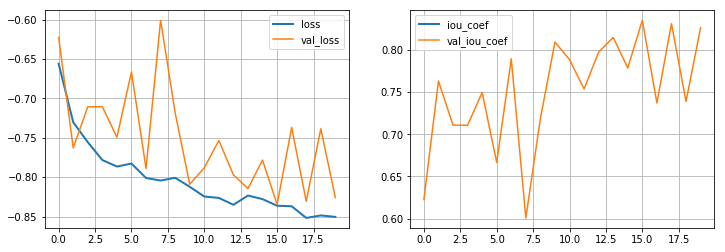

In [19]:
%%time

model_unet.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef]) 

history_unet = model_unet.fit(x_train, y_train, batch_size=batchsize, epochs=epochs, 
                    verbose=1, shuffle=True, 
                    validation_data=(x_validation, y_validation),
                    callbacks=[plotLoss])

# Predict

- some utility function to predict samples (*with uncertainties*) and plot predictions as overlays

- Predictions are based on `T` forward propagations through the model. The `mean` is used as the prediction, the `std` represents the uncertainty.

In [121]:
def predict(model, num_samples=10, T=10):
    import time
    tic = time.time()
    samples_ind = np.random.randint(0, len(images), num_samples)
    sample_images = images[samples_ind]
    sample_masks = masks[samples_ind]
    
    # repeat predictions T times with MC Dropout
    predictions = np.array([model.predict(sample_images, batch_size=4) for t in range(T)])
    print(predictions.shape)
    predictions_mean = np.mean(predictions, axis=0)
    predictions_std  = np.std( predictions, axis=0)
    print(predictions_mean.shape)
    
    toc = time.time()
    print('Time per image = {:.4f} sec'.format((toc-tic) / num_samples))
    return sample_images, sample_masks, predictions_mean, predictions_std

def images_overlay(im1, im2, threshold=1e-2, title=None, lines=True, alpha=0.25, cmap='Reds_r', ax=None, figsize=(5,5)):
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        
    im1 = np.squeeze(im1)
    im2 = np.squeeze(im2)
    
    ax.imshow(im1)
    
    if threshold is not None:
        mask = np.ma.masked_less(im2, threshold)
        ax.contourf(mask >= threshold, alpha=alpha, cmap=cmap)
    else:
        ax.imshow(im2, alpha=alpha, cmap=cmap)
    if lines:
        ax.contour(im2, levels=[threshold], alpha=1.0, cmap=cmap)

    ax.axis('off')
    
    if title is not None:
        ax.set_title(title, fontsize=14)
        
def plot_prediction(x, y, y_pred_mu, y_pred_sigma, sample):
    
    if sample >= len(y_pred_mu):
        raise ValueError('sample {} does not exist, max = {}'.format(sample, len(y_pred_mu)-1))
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    images_overlay(x[sample], y_pred_mu   [sample], ax=ax[0], title='prediction', threshold=0.5, alpha=0.5)
    images_overlay(x[sample], y_pred_sigma[sample], ax=ax[1], title='uncertainty', alpha=0.70, cmap='viridis', lines=False, threshold=None)
    images_overlay(x[sample], y[sample], ax=ax[2], title='annotation', threshold=1e-2)
    

In [122]:
%%time
num_samples = 10
x, y, y_pred_mu, y_pred_sigma = predict(model_unet, num_samples=num_samples, T=20)

(20, 10, 320, 448, 1)
(10, 320, 448, 1)
Time per image = 0.6755 sec
CPU times: user 5.34 s, sys: 1.75 s, total: 7.1 s
Wall time: 6.76 s


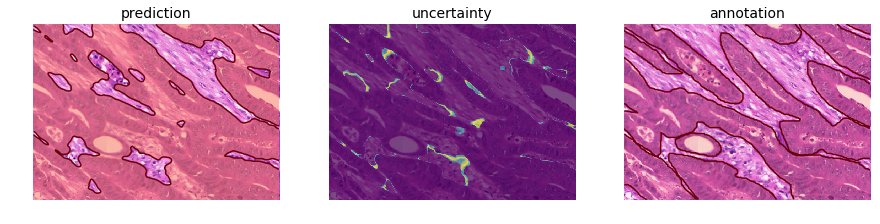

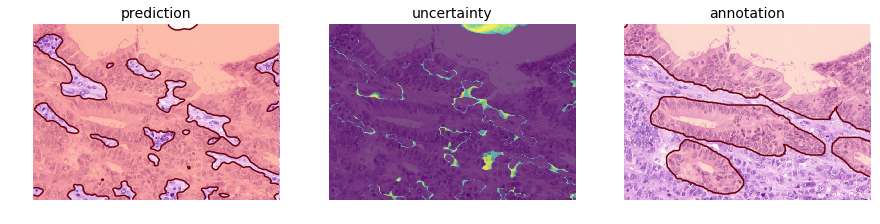

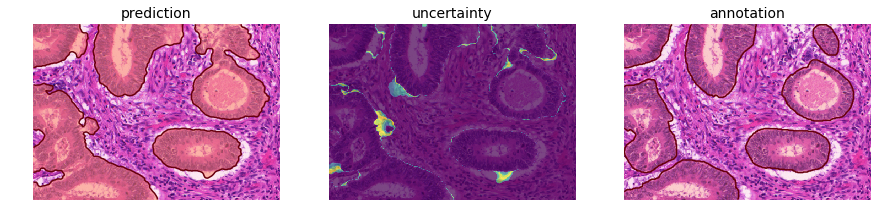

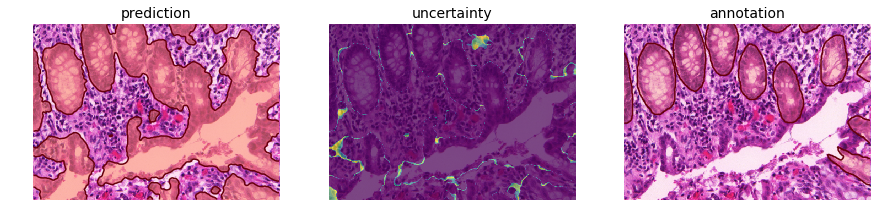

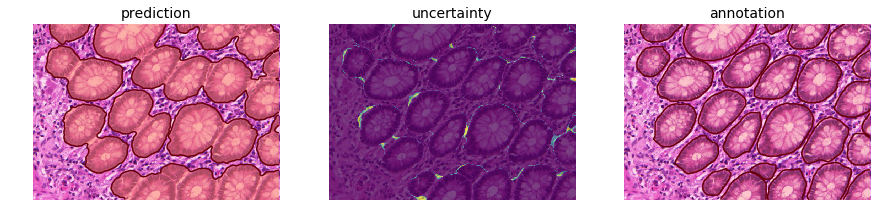

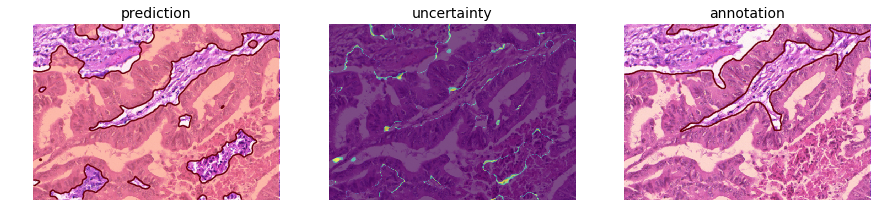

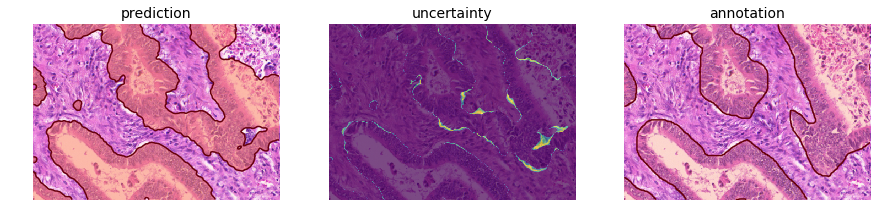

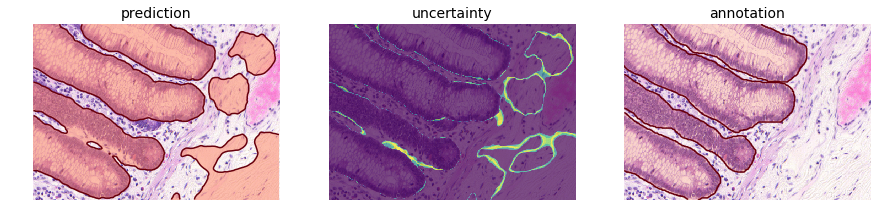

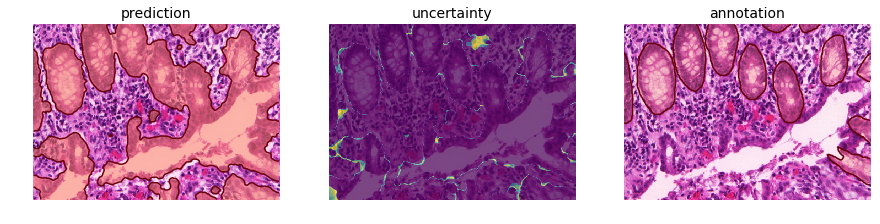

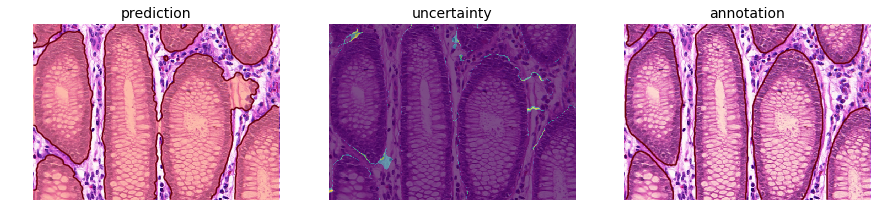

In [123]:
_ = [plot_prediction(x, y, y_pred_mu, y_pred_sigma, sample=i) for i in range(num_samples)]